In [43]:
import os
import sys
sys.path.append('src/iVAE')
import yaml
import matplotlib.pyplot as plt

from src.iVAE.data import SyntheticDataset
from src.iVAE.models import cleanIVAE
from src.iVAE.models import load_checkpoint

import torch
from torch import optim

import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('src/fast_ica')
from fast_ica import Fast_ICA
from sklearn.decomposition import FastICA as sk_FastICA


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
config_path = os.path.join("experiments_results/exp_configs/config_exp_1.yaml")
checkpoint_path = os.path.join("experiments_results/checkpoints/1/1_seed_0_ckpt_best.pth")
dataset_path = os.path.join("experiments_results/datasets/")
config = yaml.safe_load(open(config_path, "r"))

In [35]:
dset = SyntheticDataset(
        dataset_path,
        config["nps"],
        config["ns"],
        config["dl"],
        config["dd"],
        config["nl"],
        config["s"],
        config["p"],
        config["act"],
        uncentered=config["uncentered"],
        noisy=config["noisy"],
        double= config['gamma'] > 0,
        one_hot_labels=config["one_hot"],
        simple_mixing=config["simple_mixing"],
    )
d_data, d_latent, d_aux = dset.get_dims()

loading data from experiments_results/datasets/tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz


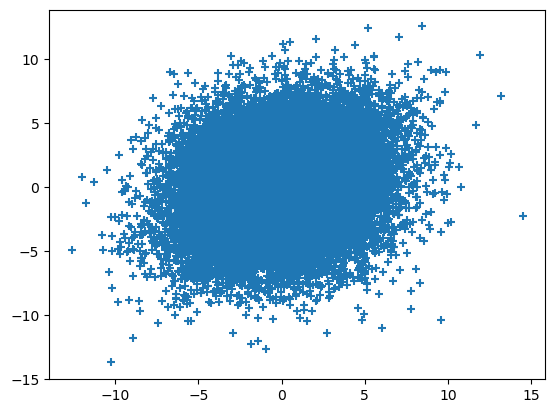

In [36]:
plt.scatter(dset.x[:, 0], dset.x[:, 2], marker="+")

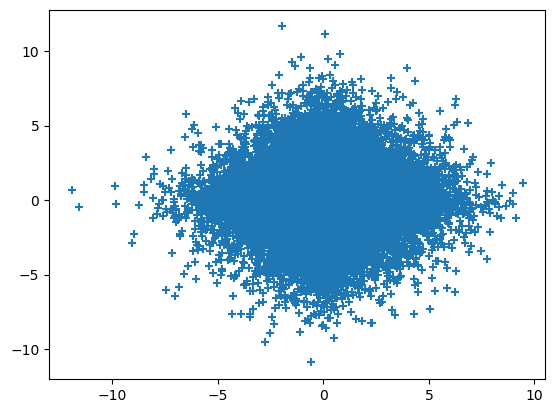

In [37]:
plt.scatter(dset.s[:, 0], dset.s[:, 2], marker="+")

## FastICA

In [11]:
ica = Fast_ICA(n_components=dset.x.shape[1], tol=1e-4)
S_ = ica.fit_transform(dset.x.T.detach().numpy(), method='parallel').T
S_

array([[-0.06115514,  0.72934023, -0.1639786 , -0.06399777, -0.46553817],
       [-0.56520153,  1.24125376, -0.08082634,  2.12540057, -0.31968885],
       [ 0.01395126, -0.13407912, -0.23097127,  0.1386975 ,  0.77372549],
       ...,
       [ 0.6416451 ,  0.32956337, -0.07947751,  0.96068174, -0.32928143],
       [ 1.56000321,  0.21399892, -2.04241923, -2.88388332,  0.24540907],
       [-0.42744468,  0.55543802, -0.51587001, -0.69174106,  0.77881349]])

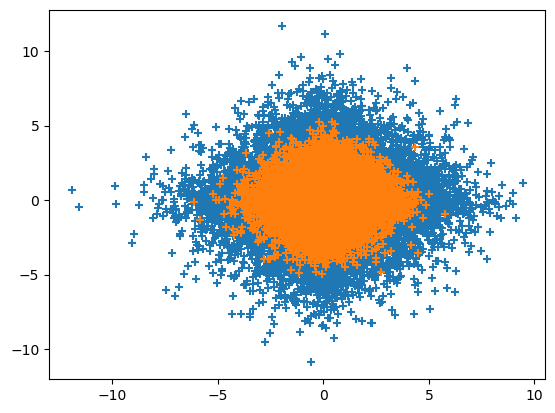

In [12]:
plt.scatter(dset.s[:, 0], dset.s[:, 2], marker="+")
plt.scatter(S_[:, 0], S_[:, 2], marker="+")

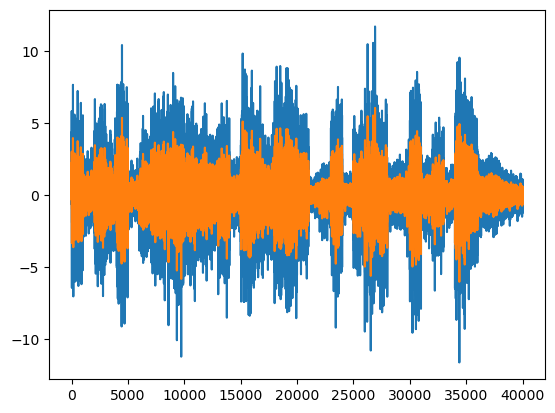

In [18]:
plt.plot(dset.s[:, 1])
plt.plot(S_[:, 1])

## iVAE

In [40]:
d_data, d_latent, d_aux = dset.get_dims()
model = cleanIVAE(
                data_dim=d_data,
                latent_dim=d_latent,
                aux_dim=d_aux,
                hidden_dim=config['hidden_dim'],
                n_layers=config['n_layers'],
                activation=config['activation'],
                slope=0.1,
            )
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
_ = load_checkpoint(model, optimizer, checkpoint_path)
model.eval()

cleanIVAE(
  (logl): MLP(
    (fc): ModuleList(
      (0): Linear(in_features=40, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=5, bias=True)
    )
  )
  (f): MLP(
    (fc): ModuleList(
      (0): Linear(in_features=5, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=5, bias=True)
    )
  )
  (g): MLP(
    (fc): ModuleList(
      (0): Linear(in_features=45, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=5, bias=True)
    )
  )
  (logv): MLP(
    (fc): ModuleList(
      (0): Linear(in_features=45, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=5, bias=True)
    )
  )
)

In [57]:
with torch.no_grad():
  _, _, _, s, _ = model(dset.x, dset.u)
  s = s.detach().numpy()

In [58]:
s

array([[ 0.1490229 , -1.2689204 ,  0.29743108, -0.01489924, -0.99819726],
       [ 0.5231295 , -0.61642677, -0.28762457, -3.8950293 , -1.6743892 ],
       [-0.3115623 ,  1.3393528 ,  0.42499727, -0.1272601 ,  0.08869971],
       ...,
       [-1.1903619 , -0.40105963, -0.11797697, -1.9421891 , -0.38705546],
       [-2.8817282 , -1.0079799 ,  3.0363393 ,  5.2216315 , -0.20422047],
       [ 0.38808352,  0.7576606 ,  1.0442711 ,  1.3171355 , -0.8342974 ]],
      dtype=float32)

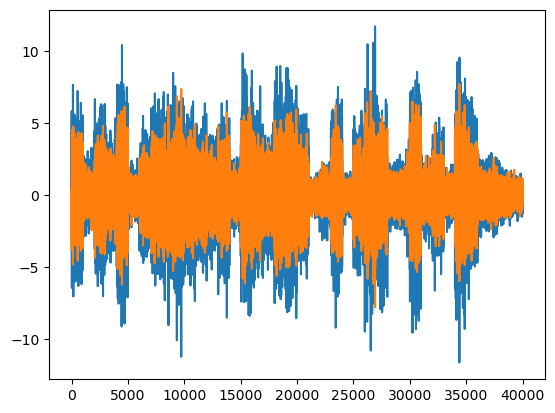

In [59]:
plt.plot(dset.s[:, 1])
plt.plot(s[:, 4])